# 10. Advanced Gradient Boosting: XGBoost, LightGBM, CatBoost

**Author:** [Your Name/GitHub Username]
**Date:** June 3, 2025

## Introduction

While Scikit-learn's `GradientBoostingClassifier` and `GradientBoostingRegressor` are powerful, several specialized libraries have been developed that offer more optimized, feature-rich, and often faster implementations of gradient boosting. This notebook explores three of the most prominent ones:

1.  **XGBoost (Extreme Gradient Boosting):** Known for its speed, performance, and regularization capabilities.
2.  **LightGBM (Light Gradient Boosting Machine):** Developed by Microsoft, known for its very high speed and efficiency, especially on large datasets.
3.  **CatBoost (Categorical Boosting):** Developed by Yandex, known for its excellent handling of categorical features and often good performance with default parameters.

These libraries have become staples in machine learning for structured/tabular data due to their ability to achieve state-of-the-art results.

* **Type:** Supervised Learning (Ensemble Method - Boosting)
* **Task:** Classification and Regression
* **Goal:** To provide highly accurate and efficient predictive models by leveraging advanced gradient boosting techniques.

## Theoretical Background

### 1. Ensemble Learning & Boosting
* **Ensemble Learning:** Combines multiple models to achieve better predictive performance than any single model.
* **Boosting:** An ensemble technique where models are built sequentially. Each new model focuses on correcting the errors made by the combination of previous models. The idea is to convert a collection of "weak learners" into a "strong learner."

### 2. Core Idea of Gradient Boosting
Gradient Boosting is an additive model where decision trees (or other weak learners) are added one at a time. Each new tree is trained to fit the **pseudo-residuals** of the previous ensemble of trees.
* **Pseudo-residuals:** These are the gradients of the loss function with respect to the predictions of the current ensemble. Essentially, they indicate the direction and magnitude of error for each sample.

The algorithm iteratively "descends" a gradient in a function space to find the model that minimizes the chosen loss function.

### 3. Algorithm Steps (Simplified)
Let $F_{m-1}(x)$ be the ensemble of $m-1$ trees. We want to add a new tree $h_m(x)$ such that $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$ further minimizes the loss, where $\nu$ is the learning rate.

1.  **Initialize Model:** Start with an initial constant prediction $F_0(x)$, often the mean of the target values (for regression) or log-odds (for classification).
2.  **Iterate for $m = 1$ to $M$ (number of trees):**
    a.  **Compute Pseudo-Residuals:** For each sample $i$, calculate the negative gradient of the loss function $L(y_i, F_{m-1}(x_i))$ with respect to the current prediction $F_{m-1}(x_i)$.
        $r_{im} = - \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)}$
    b.  **Fit a Weak Learner:** Train a new weak learner (typically a regression tree, $h_m(x)$) to predict these pseudo-residuals $r_{im}$ from the features $x_i$.
    c.  **Determine Multiplier (or update leaf values):** Find the optimal contribution of this new tree. For tree-based learners, often the output values in the terminal nodes of $h_m(x)$ are adjusted to minimize the loss.
    d.  **Update the Model:** Add the new tree to the ensemble, scaled by a learning rate $\nu$ (shrinkage):
        $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$

### 4. Key Components
* **Loss Function ($L(y, F(x))$):** Defines what the model is trying to optimize.
    * **Regression:** Common choices include Mean Squared Error (MSE), Mean Absolute Error (MAE). With MSE, the pseudo-residuals are simply $y_i - F_{m-1}(x_i)$.
    * **Classification:** Common choices include Log Loss (Deviance) for binary classification (e.g., `Bernoulli deviance`) or multi-class classification (e.g., `Multinomial deviance`).
* **Weak Learner ($h_m(x)$):** Typically, decision trees (specifically CART - Classification and Regression Trees) are used. These trees are often depth-limited (e.g., `max_depth` between 1 and 8).
* **Learning Rate ($\nu$ or Shrinkage):** A small value (e.g., 0.01, 0.05, 0.1) that scales the contribution of each tree.
    * Smaller learning rates require more trees (`n_estimators`) for the model to converge but often lead to better generalization by preventing overfitting. There's a trade-off between `learning_rate` and `n_estimators`.
* **Number of Estimators ($M$ or `n_estimators`):** The total number of trees to build. Too few trees can lead to underfitting; too many (with a high learning rate) can lead to overfitting. Often tuned using early stopping.

### 5. Regularization Techniques
To prevent overfitting, GBMs employ several regularization strategies:
* **Tree Constraints:** Limiting `max_depth`, `min_samples_split`, `min_samples_leaf` of individual trees.
* **Shrinkage (Learning Rate):** As mentioned, a small learning rate reduces the impact of each tree.
* **Subsampling (Stochastic Gradient Boosting):**
    * At each iteration $m$, fit $h_m(x)$ on a random subsample of the training data (drawn without replacement). This is controlled by the `subsample` hyperparameter (e.g., 0.5 to 0.8).
    * Can also subsample features when constructing splits within a tree (`max_features`), similar to Random Forests.
    * Introduces randomness, reduces variance, improves generalization, and can speed up training.
* **Early Stopping:** Monitor performance on a separate validation set and stop training when the validation performance no longer improves for a certain number of iterations.

### Pros
* Often provides state-of-the-art predictive accuracy on structured/tabular data.
* Can handle different types of features (numerical, categorical - though scikit-learn requires numerical input).
* Robust to outliers to some extent if using robust loss functions (though standard MSE is not).
* Can naturally handle missing data (depending on the tree implementation, though scikit-learn's requires imputation).
* Provides feature importance measures.

### Cons
* Can be prone to overfitting if not carefully tuned (e.g., if `learning_rate` is too high or `n_estimators` is too large without regularization).
* Training can be computationally intensive and slower than Random Forests because trees are built sequentially.
* Hyperparameter tuning can be more complex than for some other algorithms due to the number of interacting parameters.
* Less interpretable than single decision trees or linear models.

### Common Use Cases
* Widely used in data science competitions (Kaggle, etc.).
* Credit scoring and fraud detection.
* Recommendation systems.
* Web search ranking.
* Any classification or regression task where high accuracy is desired on tabular data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler # Less critical for GBM
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import metrics # For accuracy, confusion matrix, classification report

# Set a style for seaborn plots
sns.set_style('whitegrid')

## Implementation with Python (Gradient Boosting Classifier)

We'll use the **Breast Cancer Wisconsin dataset** for this classification example.

In [3]:
from sklearn.datasets import load_breast_cancer

# Load the dataset
cancer_data = load_breast_cancer()

# Create a Pandas DataFrame for features and a Series for the target
X_df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y_s = pd.Series(cancer_data.target, name='Target') # 0 for malignant, 1 for benign
target_names = cancer_data.target_names

print("Features (X) - First 5 rows:")
print(X_df.head())
print(f"\nTarget names: {target_names}")

Features (X) - First 5 rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  wo

In [4]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_s, test_size=0.3, random_state=42, stratify=y_s)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# 2. Feature Scaling (Discussion Point)
# Tree-based models like Gradient Boosting are generally not sensitive to feature scaling.
# The splitting decisions are based on thresholds within individual features, not on their absolute magnitudes
# relative to other features. So, scaling is usually not required for scikit-learn's GBM.

Training set size: 398
Testing set size: 171


In [5]:
# Create a Gradient Boosting Classifier instance
# Key hyperparameters:
# n_estimators: Number of boosting stages (trees) to perform.
# learning_rate: Shrinks the contribution of each tree.
# max_depth: Maximum depth of the individual regression estimators.
# subsample: Fraction of samples to be used for fitting individual base learners.
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Learning rate
    max_depth=3,            # Max depth of each tree
    subsample=0.8,          # Fraction of samples for training each tree
    random_state=42
)

# Fit the model
gb_classifier.fit(X_train, y_train)

print("Gradient Boosting Classifier trained.")

Gradient Boosting Classifier trained.


In [6]:
# Make predictions on the test set
y_pred_class = gb_classifier.predict(X_test)
y_pred_proba = gb_classifier.predict_proba(X_test) # Probabilities for each class

# Display some predictions
predictions_df = pd.DataFrame({
    'Actual Target': y_test.values,
    'Predicted Class': y_pred_class,
    'Prob_Class_0 (Malignant)': y_pred_proba[:, 0],
    'Prob_Class_1 (Benign)': y_pred_proba[:, 1]
})
print("\nActual vs Predicted classes and Probabilities (first 10):")
print(predictions_df.head(10))


Actual vs Predicted classes and Probabilities (first 10):
   Actual Target  Predicted Class  Prob_Class_0 (Malignant)  \
0              0                0                  0.995954   
1              1                1                  0.001190   
2              1                1                  0.148342   
3              0                0                  0.999050   
4              0                1                  0.202738   
5              0                0                  0.999294   
6              1                1                  0.000366   
7              0                0                  0.998020   
8              1                1                  0.000319   
9              0                0                  0.999385   

   Prob_Class_1 (Benign)  
0               0.004046  
1               0.998810  
2               0.851658  
3               0.000950  
4               0.797262  
5               0.000706  
6               0.999634  
7               0.001980  
8   

### Model Evaluation Metrics (Classification)


Test Set Accuracy: 0.9591


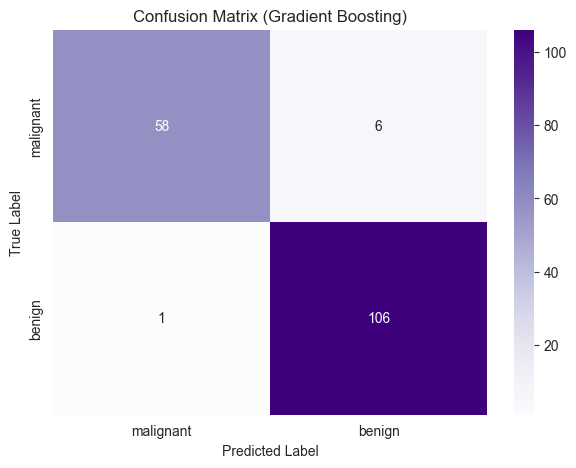


Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.91      0.94        64
      benign       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



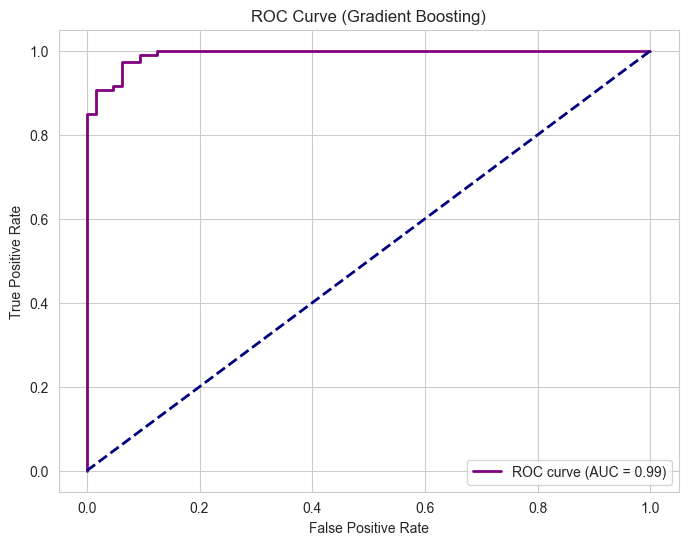

AUC Score: 0.9923


In [7]:
# 1. Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"\nTest Set Accuracy: {accuracy:.4f}")

# 2. Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Gradient Boosting)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
class_report = metrics.classification_report(y_test, y_pred_class, target_names=target_names)
print("\nClassification Report:")
print(class_report)

# 4. ROC Curve and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1]) # Probabilities of positive class (Benign=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting)')
plt.legend(loc="lower right")
plt.show()
print(f"AUC Score: {roc_auc:.4f}")

### Feature Importance
Gradient Boosting models also provide feature importance scores, typically based on how much each feature contributes to reducing the loss function across all splits in all trees.


Feature Importances from Gradient Boosting Classifier:
                 Feature  Importance
27  worst concave points    0.331136
20          worst radius    0.225355
22       worst perimeter    0.200650
23            worst area    0.084187
21         worst texture    0.037193
7    mean concave points    0.017034
1           mean texture    0.015824
24      worst smoothness    0.013079
26       worst concavity    0.011873
28        worst symmetry    0.008484


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_56431/1968333577.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='mako')


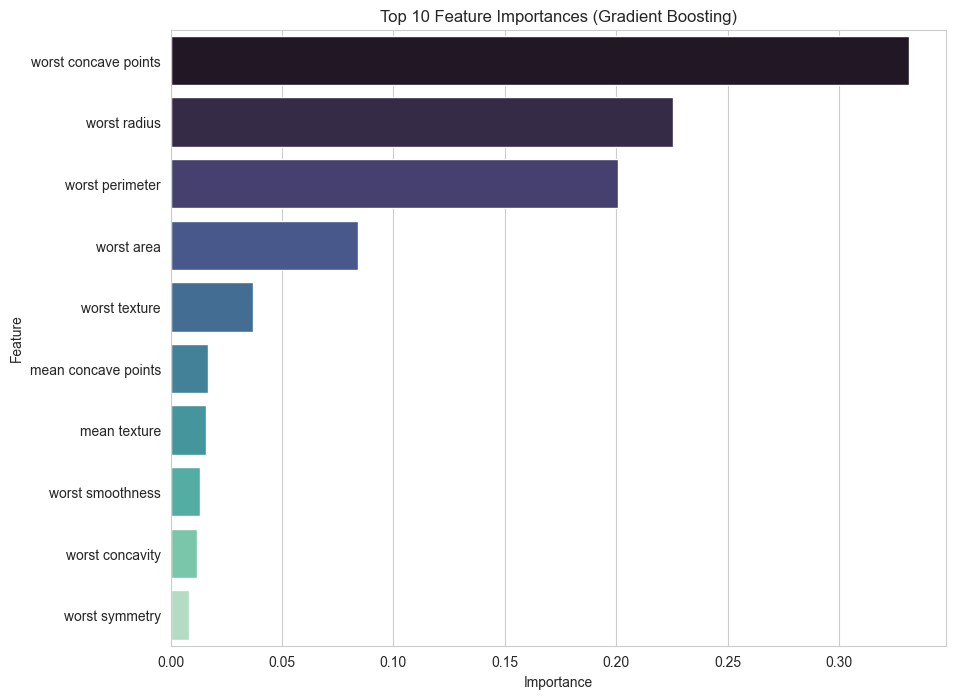

In [8]:
importances = gb_classifier.feature_importances_
feature_names = X_df.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Gradient Boosting Classifier:")
print(feature_importance_df.head(10)) # Display top 10

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='mako')
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.show()

### Staged Predictions & Early Stopping (Conceptual / Simple Demo)
`GradientBoostingClassifier` allows access to predictions at each stage (after each tree is added) via `staged_predict()` or `staged_predict_proba()`. This can be used to find the optimal number of trees by monitoring performance on a validation set (early stopping).

Scikit-learn's `GradientBoostingClassifier` has `n_iter_no_change` and `validation_fraction` parameters for built-in early stopping. If `n_iter_no_change` is set to an integer, it will use a fraction of training data as a validation set to stop training if validation score doesn't improve.


GBM with early stopping trained. Number of estimators actually used: 134
Accuracy with early stopping: 0.9591


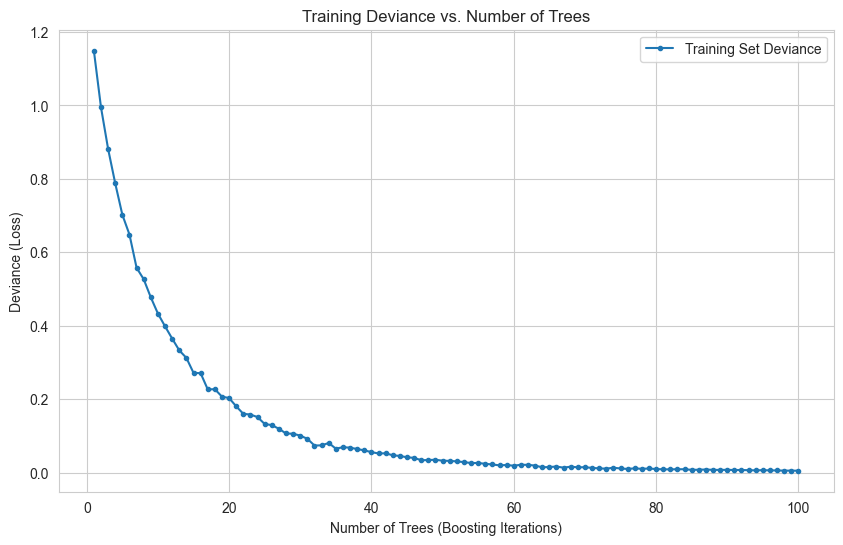

In [9]:
# --- Demonstrating n_iter_no_change for early stopping ---
gb_early_stopping = GradientBoostingClassifier(
    n_estimators=500,       # A larger number of potential trees
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    validation_fraction=0.1, # Fraction of training data to set aside as validation
    n_iter_no_change=10,     # Stop if no improvement for 10 iterations
    tol=0.0001              # Tolerance for the early stopping
)
gb_early_stopping.fit(X_train, y_train)
print(f"\nGBM with early stopping trained. Number of estimators actually used: {gb_early_stopping.n_estimators_}")

y_pred_early_stop = gb_early_stopping.predict(X_test)
accuracy_early_stop = metrics.accuracy_score(y_test, y_pred_early_stop)
print(f"Accuracy with early stopping: {accuracy_early_stop:.4f}")


# --- Plotting training deviance (loss) vs. number of trees ---
# This shows how loss decreases on the training set as more trees are added.
# gb_classifier was our model with n_estimators=100
train_loss = gb_classifier.train_score_ # Loss on training set at each iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='.', label='Training Set Deviance')
plt.xlabel('Number of Trees (Boosting Iterations)')
plt.ylabel('Deviance (Loss)')
plt.title('Training Deviance vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

The training deviance plot typically shows a decreasing trend. For proper early stopping, one would plot the deviance/error on a separate validation set against the number of trees. Scikit-learn's built-in early stopping automates this.

## Gradient Boosting for Regression (Brief Example)

Gradient Boosting can also effectively perform regression tasks. The principles are similar: trees are built sequentially to predict the residuals (when using MSE loss) of the previous ensemble.


Gradient Boosting Regression Evaluation:
Mean Squared Error (MSE): 0.2341
R-squared (R²): 0.5670


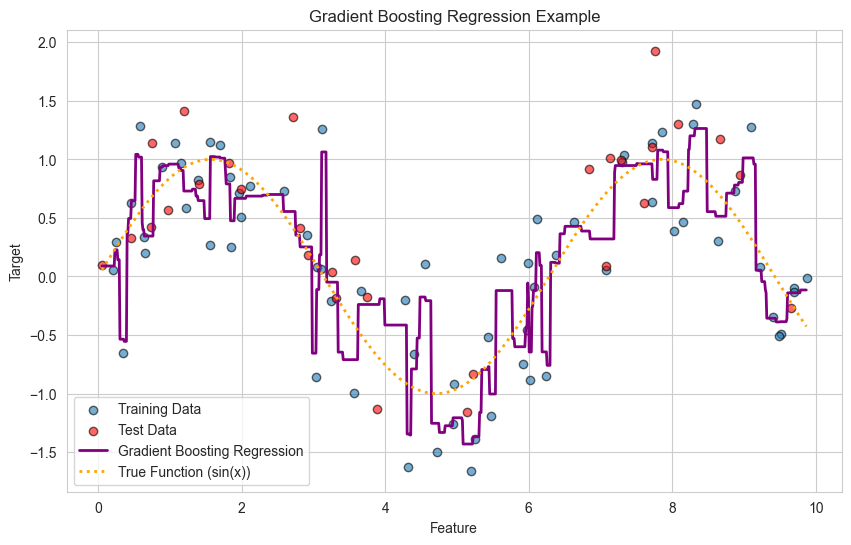

In [10]:
# Generate some simple 1D synthetic data for regression
np.random.seed(42)
X_reg = np.sort(10 * np.random.rand(100, 1), axis=0)
y_reg = np.sin(X_reg).ravel() + np.random.randn(100) * 0.5 # sin(x) + noise

# Split data
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    loss='squared_error' # 'ls' for least squares (MSE), 'lad' for least absolute deviation (MAE), 'huber', 'quantile'
)
gb_regressor.fit(X_reg_train, y_reg_train)

# Predictions
y_reg_pred = gb_regressor.predict(X_reg_test)

# Evaluation
mse_gb_reg = metrics.mean_squared_error(y_reg_test, y_reg_pred)
r2_gb_reg = metrics.r2_score(y_reg_test, y_reg_pred)
print(f"\nGradient Boosting Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse_gb_reg:.4f}")
print(f"R-squared (R²): {r2_gb_reg:.4f}")

# Plotting the results
X_plot_reg = np.arange(X_reg.min(), X_reg.max(), 0.01)[:, np.newaxis]
y_plot_pred_gb_reg = gb_regressor.predict(X_plot_reg)

plt.figure(figsize=(10, 6))
plt.scatter(X_reg_train, y_reg_train, alpha=0.6, edgecolor='k', label='Training Data')
plt.scatter(X_reg_test, y_reg_test, color='red', alpha=0.6, edgecolor='k', label='Test Data')
plt.plot(X_plot_reg, y_plot_pred_gb_reg, color='purple', linewidth=2, label='Gradient Boosting Regression')
plt.plot(X_plot_reg, np.sin(X_plot_reg), color='orange', linestyle=':', linewidth=2, label='True Function (sin(x))')
plt.title('Gradient Boosting Regression Example')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

## Hyperparameter Tuning

Effective use of Gradient Boosting often requires careful tuning of its hyperparameters. Key ones include:
* **`n_estimators`**: The number of boosting stages (trees). Usually, the more the better, up to a point where overfitting starts or computational cost becomes too high. Often determined in conjunction with `learning_rate` and early stopping.
* **`learning_rate` (shrinkage)**: Controls the contribution of each tree. Smaller values (e.g., 0.01-0.1) generally require more `n_estimators` but can lead to better generalization.
* **`max_depth`**: Maximum depth of individual trees. Deeper trees can capture more complex interactions but are more prone to overfitting. Typical values are 3-8.
* **`subsample`**: The fraction of samples used for fitting each tree (Stochastic Gradient Boosting). Values less than 1.0 can reduce variance and prevent overfitting.
* **`min_samples_split` / `min_samples_leaf`**: Control the minimum number of samples required to split a node or be at a leaf node, respectively. Help control tree complexity.
* **`max_features`**: The fraction of features to consider for the best split.

`GridSearchCV` or `RandomizedSearchCV` from scikit-learn, or more advanced hyperparameter optimization libraries like Optuna or Hyperopt, can be used to find good combinations.

## Conclusion & Key Takeaways

* Gradient Boosting Machines (GBMs) are a powerful ensemble technique that builds models sequentially, with each new model correcting the errors of the previous ones.
* They optimize a differentiable loss function using a gradient descent-like approach in function space.
* **Key Components:** Weak learners (usually decision trees), a loss function, and a learning rate (shrinkage).
* **Regularization is crucial:** Techniques like tree constraints (`max_depth`), shrinkage (`learning_rate`), and subsampling help prevent overfitting.
* **Performance:** Often achieves state-of-the-art results on tabular data for both classification and regression.
* **Trade-offs:** Can be computationally intensive and requires careful hyperparameter tuning.
* Scikit-learn provides `GradientBoostingClassifier` and `GradientBoostingRegressor`. More advanced implementations like XGBoost, LightGBM, and CatBoost (covered next) offer further optimizations and features.

## Further Reading/References (Optional)

* [Scikit-learn GradientBoostingClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [Scikit-learn GradientBoostingRegressor Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
* Original paper by Jerome H. Friedman: ["Greedy Function Approximation: A Gradient Boosting Machine." (2001)](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)
* "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman for a detailed explanation.
* StatQuest: Gradient Boost (Part 1 to 4), Clearly Explained.